## Import libraries ##

In [117]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (
    accuracy_score,
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)
from sklearn.ensemble import RandomForestClassifier

## Define functions ##

In [118]:
def initial_data_stats(df):
    """
    Takes a dataframe and produces a breakdown of all variabels and corresponding types, unique values, and counts including missing
    :param df: dataframe (whole)
    :return: A dataframe of stats
    """
    variables = []
    dtypes = []
    count = []
    unique = []
    missing = []
    pc_missing = []
    for item in df.columns:
        variables.append(item)
        dtypes.append(df[item].dtype)
        count.append(len(df[item]))
        unique.append(len(df[item].unique()))
        missing.append(df[item].isna().sum())
        pc_missing.append(round((df[item].isna().sum() / len(df[item])) * 100, 2))

    output = pd.DataFrame(
        {
            "variable": variables,
            "dtype": dtypes,
            "count": count,
            "unique": unique,
            "missing": missing,
            "pc_missing": pc_missing,
        }
    )
    return output


def remove_object(df):
    """
    Removes non float numbers from a float column (no errors so be careful when using it)
    :param df: dataframe, target the float column ie. df["column_name"]
    :return: dataframe corrected
    """
    df = pd.to_numeric(df, errors="coerce")
    df = df.dropna().astype("float64")
    return df

## Load Data and look at overview ##

In [119]:
full_data = pd.read_csv("data1.csv")

# Calculate the ratio of failures vrs non-failures
Total_targets = full_data['Target'].value_counts()
Failure_rate = Total_targets[1] / (Total_targets.sum())

# Print failure rate and initial data stats
print("\n Failure rate =", Failure_rate)
initial_data_stats(full_data)


 Failure rate = 0.19655225488687086


,variable,dtype,count,unique,missing,pc_missing
0,ComponentAge,float64,6497,112,4,0.06
1,MonthlyRunTime,float64,6497,111,0,0.00
2,Location,object,6497,2,0,0.00
3,FlowRate,float64,6497,998,0,0.00
4,OPXVolume,float64,6497,13,5692,87.61
5,MaxOutputRate,float64,6497,276,0,0.00
6,Sensor1,float64,6497,107,10,0.15
7,Sensor2,float64,6497,317,2,0.03
8,Sensor3,object,6497,188,0,0.00
9,Sensor4,float64,6497,109,9,0.14


## Notes on Data ##
- Location is low cardinality
- OPX volume too many missing - DROP
- Sensor 3 should be a float, not object. INVESTIGATE
- There's a quite low rate of failures, this may affect model performance



Remove object type from sensor 3 drop OPX volume

In [120]:

full_data = full_data.drop(["OPXVolume"], axis=1)
full_data["Sensor3"] = remove_object(full_data["Sensor3"])
if full_data["Sensor3"].dtype != float:
    raise ValueError("Mismatch in sensor 3 data type")

# Plot correlation


/var/folders/_h/6yk5cg152cv4ws6xvl8bx9kh0000gq/T/ipykernel_41233/3718004677.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = full_data.corr()


<Axes: >

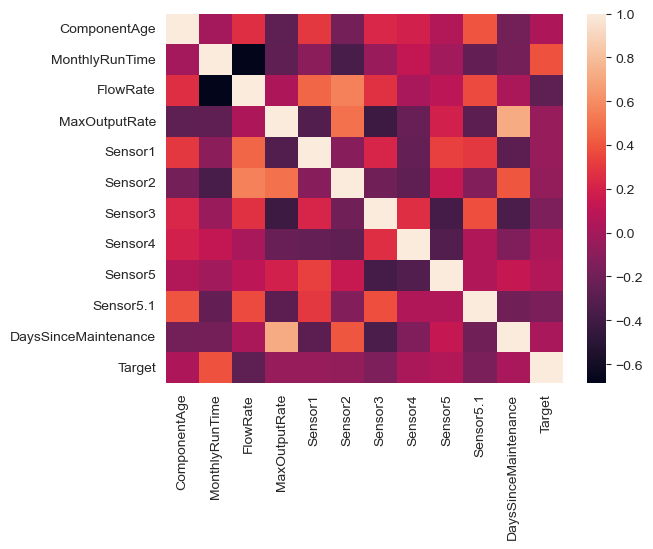

In [121]:
corr = full_data.corr()

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

# Plot variables to see data statistical spread

<Figure size 640x480 with 0 Axes>

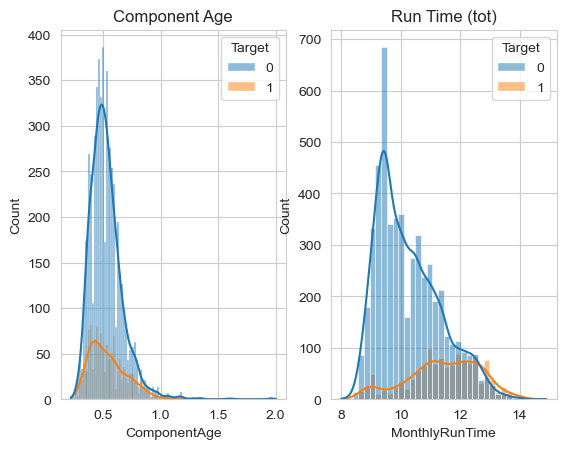

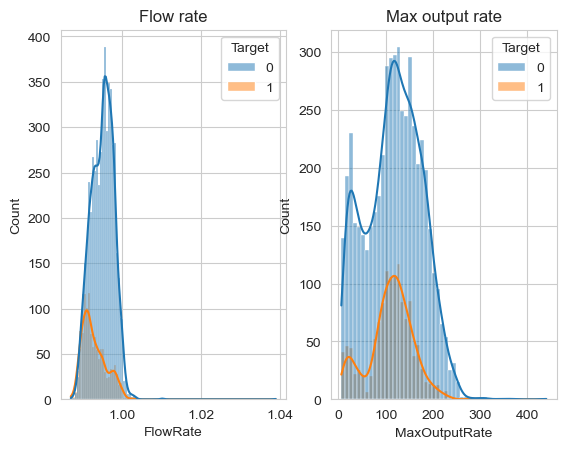

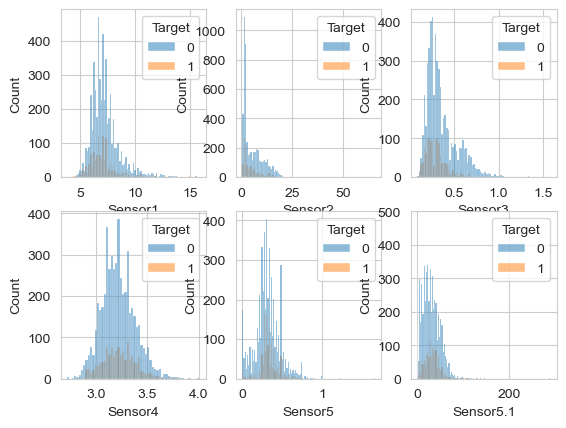

<Figure size 640x480 with 0 Axes>

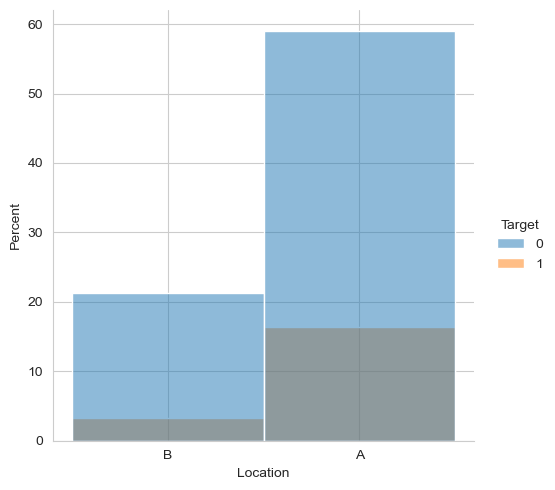

In [122]:

plt.figure(1)
fig1, ax1 = plt.subplots(1, 2)
sns.histplot(
    ax=ax1[0], data=full_data, x="ComponentAge", kde=True, hue="Target"
).set_title("Component Age")
sns.histplot(
    ax=ax1[1], data=full_data, x="MonthlyRunTime", kde=True, hue="Target"
).set_title("Run Time (tot)")

plt.figure(2)
fig2, ax2 = plt.subplots(1, 2)
sns.histplot(ax=ax2[0], data=full_data, x="FlowRate", kde=True, hue="Target").set_title(
    "Flow rate"
)
sns.histplot(
    ax=ax2[1], data=full_data, x="MaxOutputRate", kde=True, hue="Target"
).set_title("Max output rate")


plt.figure(3)
fig3, ax3 = plt.subplots(2, 3)
count = 0
hue_string = "Target"
for i in range(2):
    for j in range(3):
        if count < 5:
            sns.histplot(
                ax=ax3[i, j], data=full_data, x=f"Sensor{count + 1}", hue=hue_string
            )
        else:
            sns.histplot(ax=ax3[1, 2], data=full_data, x="Sensor5.1", hue=hue_string)
        count = count + 1


plt.figure(4)
sns.histplot(data=full_data, x="DaysSinceMaintenance", hue="Target")

plt.figure(5)
sns.displot(data=full_data, x="Location", stat="percent", hue="Target")

# General Comments
- Component age outliers above 1.25 (realistically 1), no real change in distribution between failure [1] and not, however long life component ages are vital. KEEP
- Monthly run time, non-Gaussian but fair spread
- All sensors have higher counts at location A
- Days since maintenance has a large outlier, but again this is expected to be critical so KEEP
- Failure rate is about equal, sensors more weighted on A accounts for higher count, suggesting no bias of location

# Cutoffs
- Component Age: 1.15
- Days Since m: 150
- Flow rate : 1.01
- Max output: 300
- s2: 2.5
- s5: 1


# Correlations
**Max output with:**
- days since
- s2
- Comp age
- Runtime


**Flow rate with:**
- s2
- Runtime


**removing outliers reduces model performance so has been removed**

# Plot correlations from above to sense check

Text(0.5, 1.0, 'Flow rate vs run time')

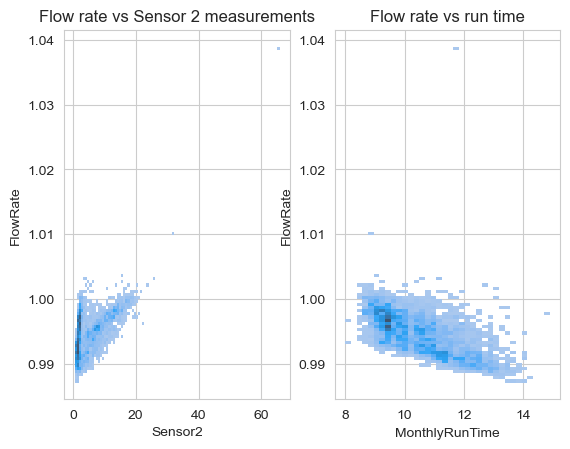

In [123]:
fig1, axs1 = plt.subplots(1, 2)
sns.histplot(ax=axs1[0], data=full_data, x="Sensor2", y="FlowRate").set_title(
    "Flow rate vs Sensor 2 measurements"
)
sns.histplot(ax=axs1[1], data=full_data, x="MonthlyRunTime", y="FlowRate").set_title(
    "Flow rate vs run time"
)

This makes sense, higher sensor measurments, higher flow rate. Its just 2 sticks out as it is the most "busy". Keep an eye on this as doesn't quite hold up for 3.

Higher flow rate for a higher run time, makes sense if material degrades or clogs over time

# Finally, start modelling

1) split the features
2) create pipeline to treat data (look at stats to see the best central tendency to use)
3) Test and train split
4) apply model with cross fold validation
5) Make predictions




In [124]:
features_num_mean = [
    "ComponentAge",
    "Sensor1",
    "Sensor3",
    "Sensor4",
    "Sensor5",
    "Sensor5.1",
    "DaysSinceMaintenance",
]

features_num_median = [
    "MonthlyRunTime",
    "FlowRate",
    "MaxOutputRate",
]

features_num_mf = [
    "Sensor2",
]
features_cat = [
    "Location",
]

transformer_num_mean = make_pipeline(
    SimpleImputer(strategy="mean"),
    StandardScaler(),
)
transformer_num_median = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
)
transformer_num_mf = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown="ignore"),
)

preprocessor = make_column_transformer(
    (transformer_num_mean, features_num_mean),
    (transformer_num_median, features_num_median),
    (transformer_num_mf, features_num_mf),
    (transformer_cat, features_cat),
)

# The encoding of most of this is redundant, because most have full columns. however, it's easier to keep a consistent format for if the data changes and computationally *shouldn't* matter

In [125]:
# Split target from data set
variable_data = full_data.copy()
target_data = variable_data.pop("Target")
column_titles = variable_data.columns.values.tolist()



X_train, X_valid, y_train, y_valid = train_test_split(
    variable_data, target_data, stratify=target_data, train_size=0.75
)



(6497, 12) (6497,)


# Logistic Regression model

logistic cross val scores:[0.40071453 0.39074947 0.41696926 0.38954596 0.39057353]
logistic cross val mean:0.39771054695622776
Logistic accuracy: 0.8326153846153846


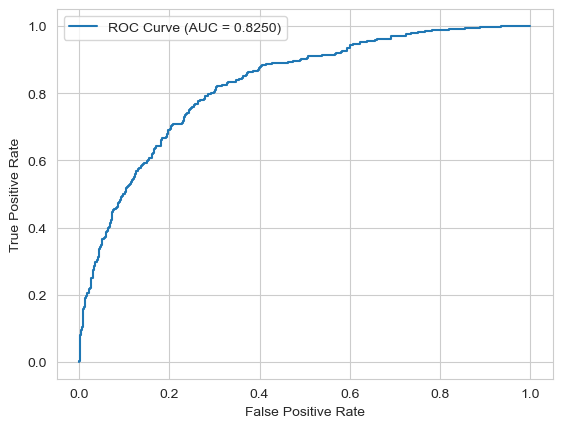

In [126]:

logistic_model = LogisticRegression()

#Make pipeline
pipeline_lr = make_pipeline(preprocessor, logistic_model)
logistic_scores = cross_val_score(
    pipeline_lr,
    X_train,
    y_train,
    cv=5,
    scoring="neg_log_loss",
)

#Fit and predict pipeline
pipeline_lr.fit(X_train, y_train)

logistic_predictions = pipeline_lr.predict(X_valid)


#Create model performance measures
logistic_accuracy = accuracy_score(y_valid, logistic_predictions)

y_pred_proba_lr = pipeline_lr.predict_proba(X_valid)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_valid, y_pred_proba_lr)
auc = roc_auc_score(y_valid, y_pred_proba_lr)

#Print and plot measures
print(f"logistic cross val scores:{-logistic_scores}")
print(f"logistic cross val mean:{-logistic_scores.mean()}")
print(f"Logistic accuracy: {logistic_accuracy}")

# create ROC curve
plt.plot(fpr_lr, tpr_lr, label="ROC Curve (AUC = {:.4f})".format(auc))
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend()
plt.show()

# Now try Logistic Regression CV

In [128]:
logistic_model_cv = LogisticRegressionCV(cv=5, scoring="neg_log_loss", max_iter=1000)
pipeline_lr_cv = make_pipeline(preprocessor, logistic_model_cv)
pipeline_lr_cv.fit(X_train, y_train)
param_grid_lr_cv = {
    'logisticregressioncv__Cs': [1, 2, 5, 10],
    'logisticregressioncv__penalty': ['l1', 'l2'],
    'logisticregressioncv__solver': ['liblinear', 'saga'],
}




grid_search_lr_cv = GridSearchCV(estimator=pipeline_lr_cv, param_grid=param_grid_lr_cv, cv=5, verbose=2, n_jobs=-1)
grid_result_lr_cv = grid_search_lr_cv.fit(X_train, y_train)



print("Best params for regression:", grid_result_lr_cv.best_params_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params for regression: {'logisticregressioncv__Cs': 10, 'logisticregressioncv__penalty': 'l2', 'logisticregressioncv__solver': 'saga'}


In [129]:
lr_cv = grid_result_lr_cv.best_estimator_
lr_cross_val_gs_cv = cross_val_score(lr_cv, X_train, y_train, cv=5, scoring="neg_log_loss")

print(f"logistic cross val scores:{-logistic_scores}")
print(f"logistic cross val mean:{-logistic_scores.mean()}")
print(f"Cross val: Logistic_cv = {-lr_cross_val_gs_cv}")
print(f"Cross val mean: Logistic_cv = {-lr_cross_val_gs_cv.mean()}")


logistic cross val scores:[0.40071453 0.39074947 0.41696926 0.38954596 0.39057353]
logistic cross val mean:0.39771054695622776
Cross val: Logistic_cv = [0.4008559  0.39076004 0.41703481 0.38950835 0.39030413]
Cross val mean: Logistic_cv = 0.39769264567655604


In [130]:
lr_cv_predicts = lr_cv.predict(X_valid)
lr_cv_accuracy = accuracy_score(y_valid, lr_cv_predicts)


y_pred_proba_lr_cv = pipeline_lr_cv.predict_proba(X_valid)[:, 1]
fpr_lr_cv, tpr_lr_cv, _ = roc_curve(y_valid, y_pred_proba_lr_cv)
auc_lr_cv = roc_auc_score(y_valid, y_pred_proba_lr_cv)

# Random Forest Model


In [131]:

pipeline_rf = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("randomforestclassifier", RandomForestClassifier(50, random_state=0)),
    ]
)

pipeline_rf.fit(X_train, y_train)

print(f"Cross val score raw = {cross_val_score(pipeline_rf, X_train, y_train, cv=5)}")
print(f"Cross val mean = {cross_val_score(pipeline_rf, X_train, y_train, cv=5).mean()}")


Cross val score raw = [0.86666667 0.87076923 0.86550308 0.88603696 0.87166324]
Cross val mean = 0.8721278365713683


# Do a grid search to optimise random forest params

In [132]:
# Create grid search parameters and apply


n_estimators = [10, 100, 1000, 2000]
max_depth = [None, 10, 20, 50]
leaf_samples = [1, 2, 3, 4, 5, 10]
param_grid_rf = {
    "randomforestclassifier__n_estimators": n_estimators,
    "randomforestclassifier__max_depth": max_depth,
    "randomforestclassifier__min_samples_leaf": leaf_samples,
}


# search the grid
grid_search_rf = GridSearchCV(
    estimator=pipeline_rf, param_grid=param_grid_rf, cv=5, verbose=2, n_jobs=-1
)
#Fit this for estimator and cross val
grid_result_rf = grid_search_rf.fit(X_train, y_train)

print("Best params:", grid_result_rf.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best params: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 1000}


In [133]:
#Use optimised model for cross  val
rf = grid_result_rf.best_estimator_
rf_cross_val_gs = cross_val_score(rf, X_train, y_train, cv=5)


print(f"Cross val score raw (grid search) = {rf_cross_val_gs}")
print(f"Cross val mean (grid search) = {rf_cross_val_gs.mean()}")

Cross val score raw (grid search) = [0.87692308 0.87282051 0.87063655 0.89117043 0.8788501 ]
Cross val mean (grid search) = 0.8780801347865003


This is a bit better!

Now make predictions and check model accuracy!


In [134]:
rf_predicts = rf.predict(X_valid)
rf_accuracy = accuracy_score(y_valid, rf_predicts)


y_pred_proba_rf = pipeline_rf.predict_proba(X_valid)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_valid, y_pred_proba_rf)
auc_rf = roc_auc_score(y_valid, y_pred_proba_rf)

Random Forest accuracy = 0.8966153846153846 
 Logistic Regression accuracy = 0.8326153846153846


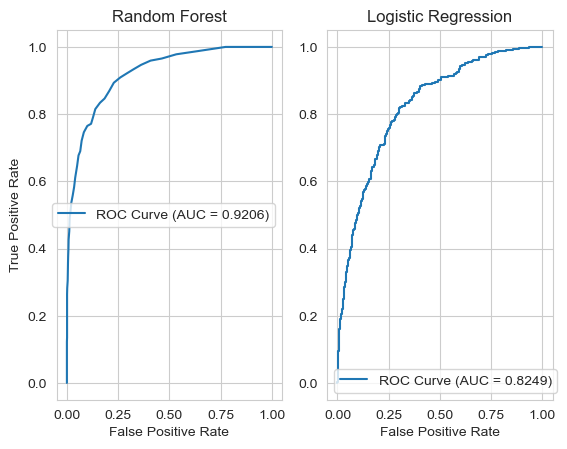

In [137]:
print(
    f"Random Forest accuracy = {rf_accuracy} \n Logistic Regression accuracy = {lr_cv_accuracy}"
)


# create ROC curve
fig, ax = plt.subplots(1, 2)
ax[0].plot(fpr_rf, tpr_rf, label="ROC Curve (AUC = {:.4f})".format(auc_rf))
ax[0].set_ylabel("True Positive Rate")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_title("Random Forest")
ax[0].legend()

ax[1].plot(fpr_lr, tpr_lr, label="ROC Curve (AUC = {:.4f})".format(auc_lr_cv))
ax[1].set_xlabel("False Positive Rate")
ax[1].set_title("Logistic Regression")
ax[1].legend()

plt.show()

In [136]:
#Print confusion matrix and classification reports for optimised models

print("Random Forest confusion matrix: \n", confusion_matrix(y_valid, rf_predicts))
print(
    "Random Forest classification report: \n",
    classification_report(y_valid, rf_predicts),
)

print(
    "\n Logistic regression confusion matrix: \n",
    confusion_matrix(y_valid, lr_cv_predicts),
)
print(
    "Logistic regression classification report: \n",
    classification_report(y_valid, lr_cv_predicts),
)

Random Forest confusion matrix: 
 [[1280   26]
 [ 142  177]]
Random Forest classification report: 
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      1306
           1       0.87      0.55      0.68       319

    accuracy                           0.90      1625
   macro avg       0.89      0.77      0.81      1625
weighted avg       0.89      0.90      0.89      1625


 Logistic regression confusion matrix: 
 [[1258   48]
 [ 224   95]]
Logistic regression classification report: 
               precision    recall  f1-score   support

           0       0.85      0.96      0.90      1306
           1       0.66      0.30      0.41       319

    accuracy                           0.83      1625
   macro avg       0.76      0.63      0.66      1625
weighted avg       0.81      0.83      0.81      1625



## Final Comments
- Random forest is much better
- Still and issue with accurately predicting failures, misclassified non-failures as failures. This is better than missing them but still, expensive for business.
- Requires more data more likely as big imbalance in Target non-failures than failures
- This follows on from reducing accuracy by removing outliers, as removing possible targets has more of an effect than keeping statistical behaviour (i.e. Gaussian)
- Could further fine tune model, with hyper-parameters, but this is assumed to have less of an impact